In [1]:
# %matplotlib qt
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from rastermap import Rastermap
from scipy.stats import zscore

spks_noITI = np.load('/Users/josefbitzenhofer/Documents/code/viral/data/cached_for_rastermap/JB027_2025-02-26_corridor_neur_noITI.npz')["spks"]
spks = np.load('/Users/josefbitzenhofer/Documents/code/viral/data/cached_for_rastermap/JB027_2025-02-26_corridor_neur.npz')["spks"]
behaviour_noITI = np.load('/Users/josefbitzenhofer/Documents/code/viral/data/cached_for_rastermap/JB027_2025-02-26_corridor_behavior_noITI.npz')
behaviour = np.load('/Users/josefbitzenhofer/Documents/code/viral/data/cached_for_rastermap/JB027_2025-02-26_corridor_behavior.npz')

In [2]:
nNeurons = spks.shape[0]

In [3]:
# Cluster on neural data without ITI
model = Rastermap(n_PCs=200, n_clusters=100, 
                  locality=1, time_lag_window=5).fit(spks_noITI)
isort = model.isort
cc_nodes = model.cc
X = spks[isort, :]


2025-03-22 14:19:55,967 [INFO] normalizing data across axis=1
2025-03-22 14:19:56,361 [INFO] projecting out mean along axis=0
2025-03-22 14:19:56,556 [INFO] data normalized, 0.59sec
2025-03-22 14:19:56,557 [INFO] sorting activity: 656 valid samples by 52733 timepoints
2025-03-22 14:19:59,027 [INFO] n_PCs = 200 computed, 3.06sec
2025-03-22 14:19:59,267 [INFO] 100 clusters computed, time 3.30sec


/Users/josefbitzenhofer/Documents/code/viral/.venv/lib/python3.12/site-packages/rastermap/cluster.py:138: UserWarning: found fewer than half the n_clusters that the user specified, rerunning with random initialization
  warnings.warn(


2025-03-22 14:20:30,579 [INFO] clusters sorted, time 34.61sec
2025-03-22 14:20:30,682 [INFO] clusters upsampled, time 34.72sec
2025-03-22 14:20:31,695 [INFO] rastermap complete, time 35.73sec


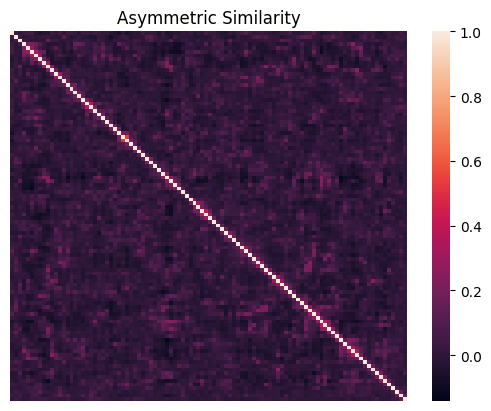

In [4]:
plt.figure()
sns.heatmap(cc_nodes)
plt.xticks([])
plt.yticks([])
plt.title("Asymmetric Similarity")
plt.show()

In [ ]:
# from Stringer et al. 2025
def bin1d(X, bin_size, axis=0):
    """ mean bin over axis of data with bin bin_size """
    if bin_size > 0:
        size = list(X.shape)
        Xb = X.swapaxes(0, axis)
        size_new = Xb.shape
        Xb = Xb[:size[axis]//bin_size*bin_size].reshape((size[axis]//bin_size, bin_size, *size_new[1:])).mean(axis=1)
        Xb = Xb.swapaxes(axis, 0)
        return Xb
    else:
        return X

In [6]:
# from Stringer et al. 2025
kp_colors = np.array([[0.55,0.55,0.55],
                      [0.,0.,1],
                      [0.8,0,0],
                      [1.,0.4,0.2],
                      [0,0.6,0.4],
                      [0.2,1,0.5],
                      ])

In [7]:
bin_size = 5
X_zs = zscore(bin1d(X, bin_size, axis=0), axis=1)

In [8]:
corridor_starts = behaviour["corridor_starts"]
corridor_widths = behaviour["corridor_widths"]
VRpos = behaviour["VRpos"]
reward_idx = behaviour["reward_inds"]
lick_idx = behaviour["lick_inds"]
run = behaviour["run"]

In [9]:
sampling_rate = 30 # fps

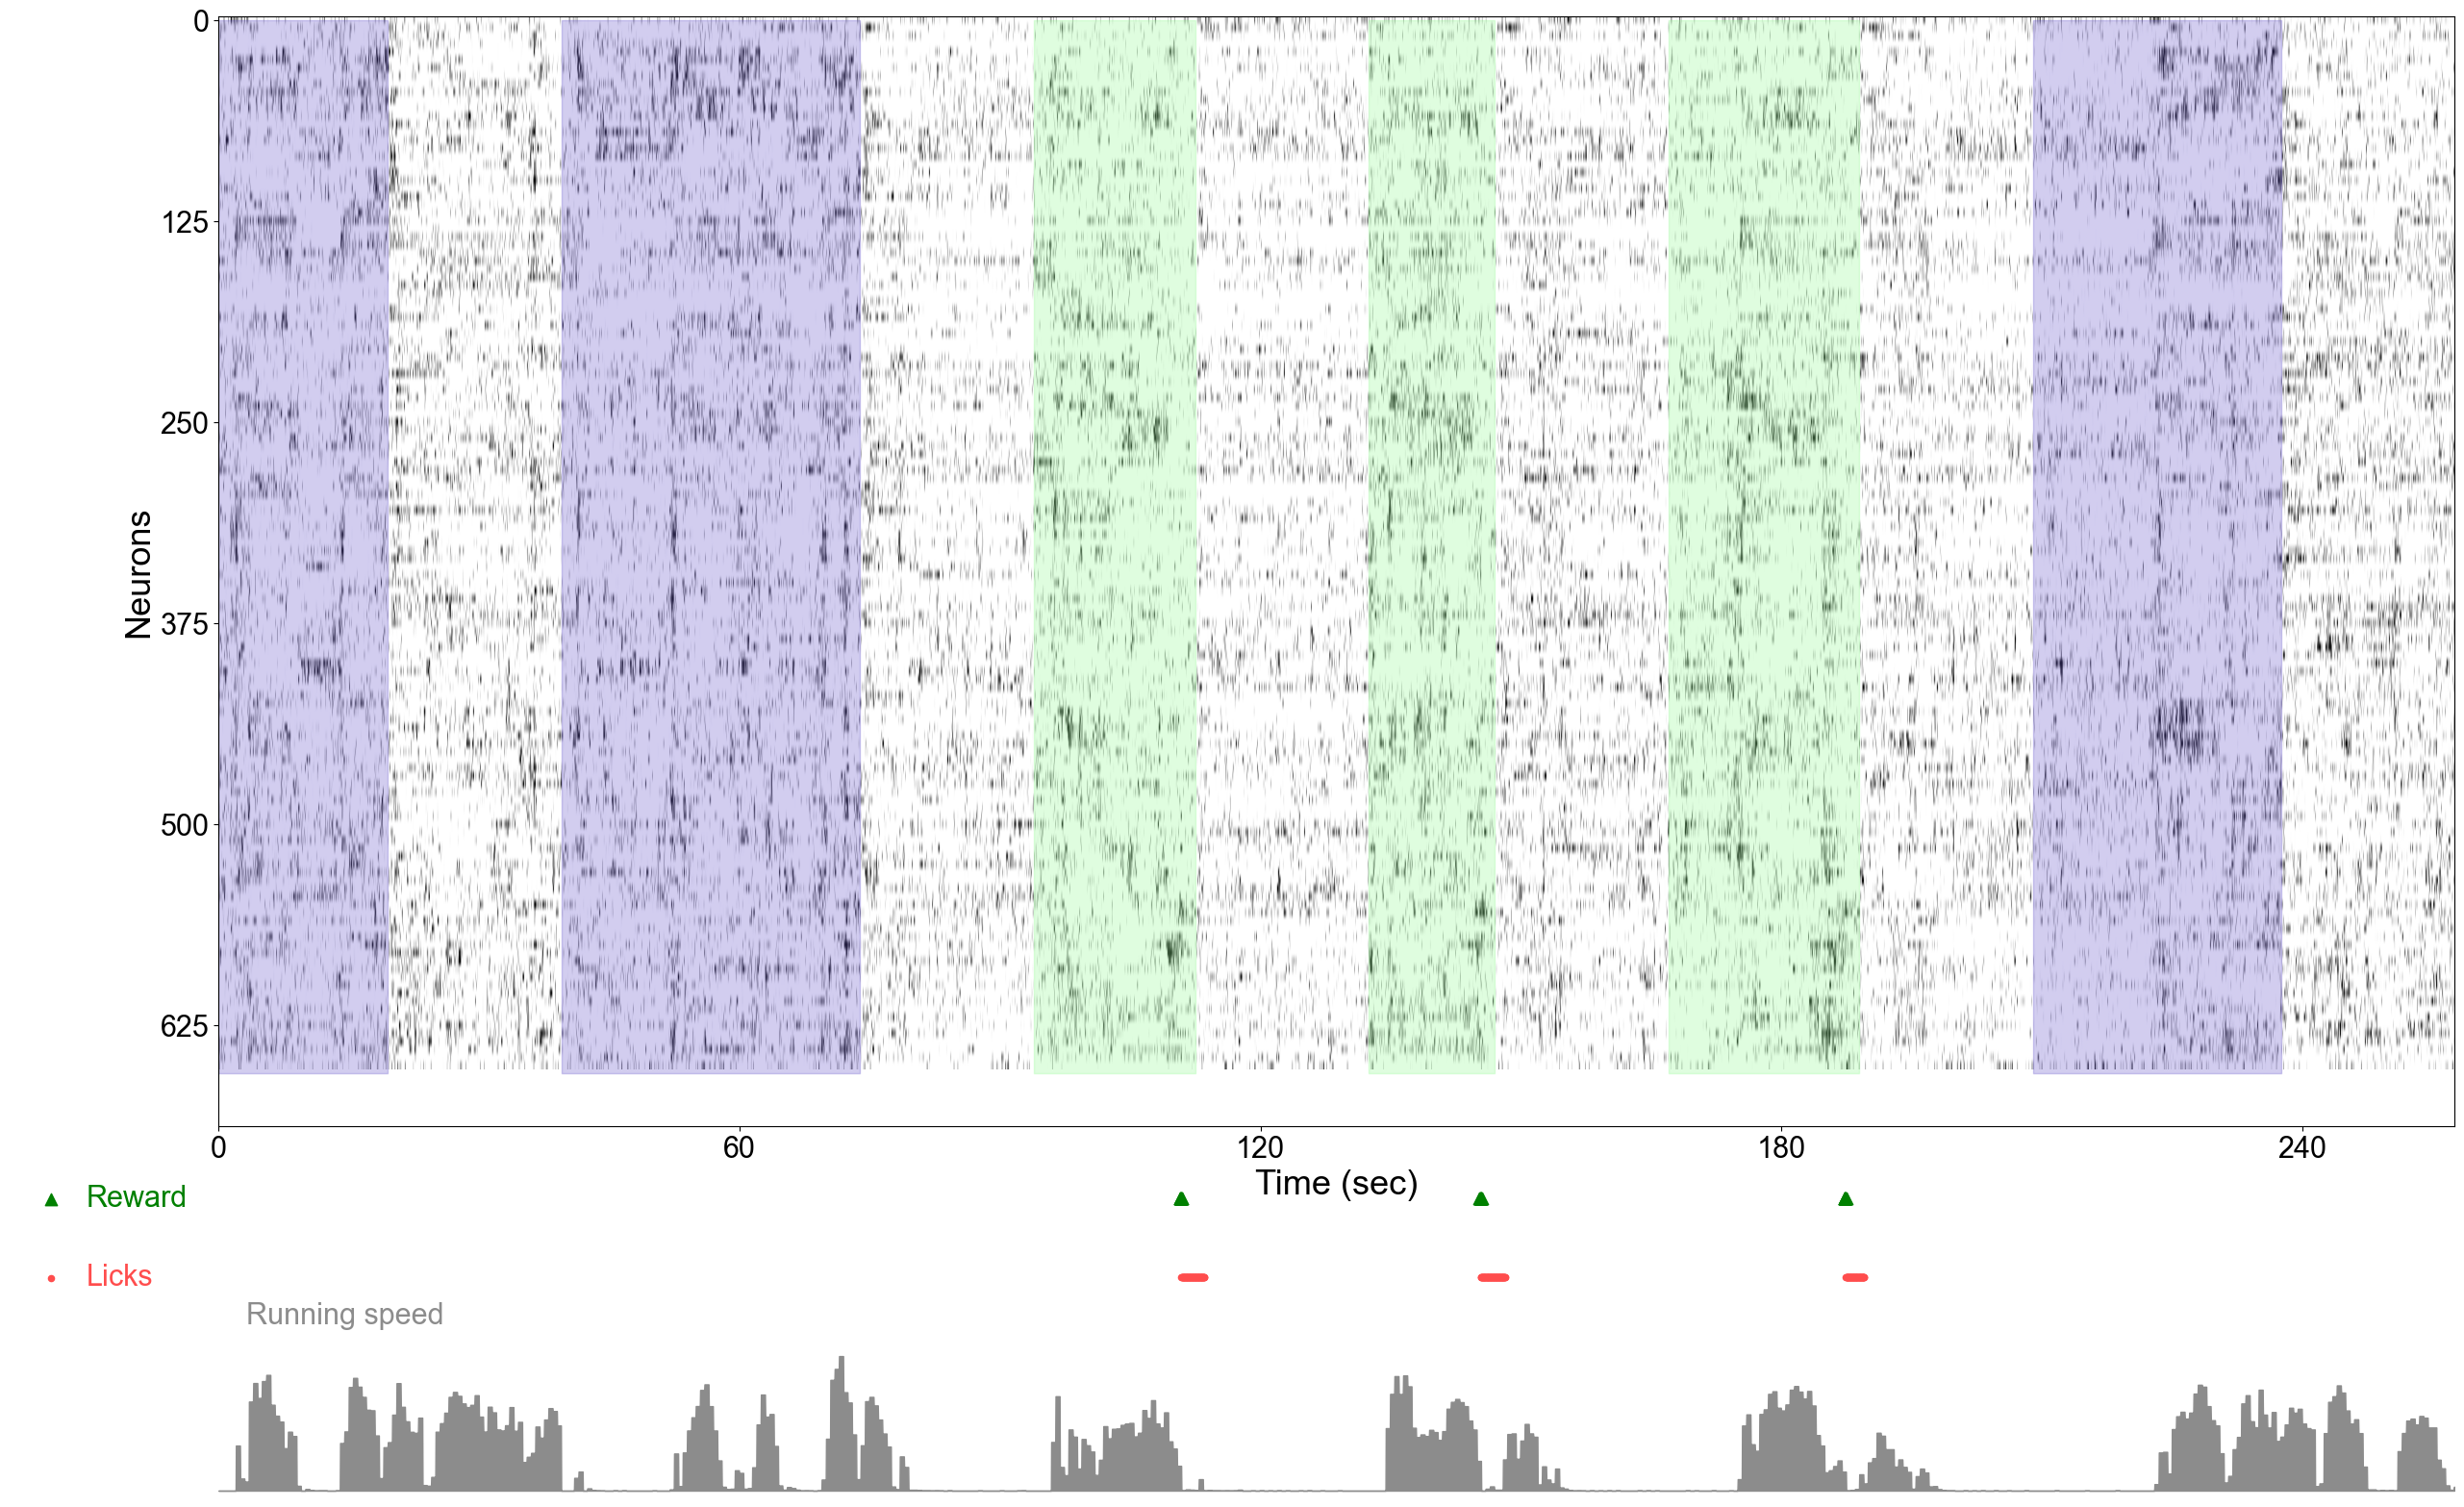

In [ ]:
# Plot on whole neural data
start_trial = 84
end_trial = 89
plot_start = int(corridor_starts[start_trial, 0])
plot_end = int(corridor_starts[end_trial, 0] + corridor_widths[end_trial] + 20 * sampling_rate)
to_plot = X_zs[:, plot_start:plot_end]
nTimepoints = to_plot.shape[1]
xticks = np.arange(0, nTimepoints, sampling_rate * 60) # every 60 seconds
xticks_labels = (xticks // sampling_rate).astype(int)
yticks = np.arange(0, nNeurons, 25)  # every 25th neuron
yticks_labels = np.arange(0, (nNeurons * 25), (25 * bin_size))

if yticks_labels[-1] > nNeurons:
    yticks_labels = yticks_labels[:-1]

yticks_labels = yticks_labels[:len(yticks)]

lick_idx_plot = lick_idx[(lick_idx >= plot_start) & (lick_idx < plot_end)] - plot_start
reward_idx_plot = reward_idx[(reward_idx >= plot_start) & (reward_idx < plot_end)] - plot_start

n_features = 4

# Scaling of the rasterplot
vmin = 0.75
vmax = 2

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 22


fig, ax = plt.subplots(nrows=n_features, ncols=1, figsize=(30, 20), gridspec_kw={"height_ratios": [15, .2, .2, 2], "hspace": 0.2}) #, sharex=True)

# NEURONS RASTERPLOT
ax1 = ax[0]
ax1.imshow(to_plot, vmin=vmin, vmax=vmax, cmap="gray_r", aspect="auto")
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks_labels)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks_labels)
ax1.set_xlabel("Time (sec)", fontsize=26)
ax1.set_ylabel("Neurons", fontsize=26)

# TODO: y-axis is weird
# TODO: make it right!

for (start, reward_condition), width in zip(corridor_starts[start_trial:end_trial + 1, :], corridor_widths[start_trial:end_trial+1]):
    ax1.fill_betweenx(
        y=[0, to_plot.shape[0]],
        x1=start - plot_start,
        x2=start + width - plot_start,  
        color="palegreen" if reward_condition == 1 else "slateblue",
        alpha=0.3
    )


# REWARDS
ax2 = ax[1]
ax2.scatter(
    reward_idx_plot,  # Align with the time window
    np.ones(len(reward_idx_plot)), 
    color="g",
    marker="^", 
    s=80
)
ax2.axis("off")
ax2.legend(["Reward"], loc="center left", frameon=False, handletextpad=0.2, bbox_to_anchor=(-0.1, 0.5), labelcolor="g")

# LICKING
ax3 = ax[2]
ax3.scatter(
    lick_idx_plot,  # Align with the time window
    np.ones(len(lick_idx_plot)), 
    color=[1.0,0.3,0.3],
    marker=".", 
    s=80
)
ax3.axis("off")
ax3.legend(["Licks"], loc="center left", frameon=False, handletextpad=0.2, bbox_to_anchor=(-0.1, 0.5), labelcolor=[1.0,0.3,0.3])


# RUNNING SPEED
ax4 = ax[3]
ax4.fill_between(np.arange(nTimepoints), run[plot_start:plot_end], color=kp_colors[0]) #alpha=0.5)
ax4.axis("off")
ax4.legend([matplotlib.lines.Line2D([0], [0], color=kp_colors[0])], ["Running speed"], loc="upper left", frameon=False, handlelength=0, bbox_to_anchor=(-0.01, 1.5), labelcolor=kp_colors[0])



ax1.set_xlim([0, nTimepoints])
ax2.set_xlim([0, nTimepoints])
ax3.set_xlim([0, nTimepoints])
ax4.set_xlim([0, nTimepoints])

plt.savefig(f"/Users/josefbitzenhofer/Documents/code/viral//plots/rasterplot.svg", dpi=300)
plt.show()